<a href="https://colab.research.google.com/github/wogur9503/AI-bootcamp-/blob/main/GenderClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project : 외형을 이용한 성별 분류

In [1]:
!pip install pdpbox

In [2]:
!pip install eli5

In [3]:
pip install --upgrade category_encoders

     |████████████████████████████████| 82 kB 441 kB/s 


In [4]:
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC
from sklearn import svm, metrics, model_selection
from sklearn.metrics import confusion_matrix
from category_encoders import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
# 성별 분류 데이터
df = pd.read_csv('gender_classification_v7.csv')
target = 'gender'
df.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


독립변수(x_n) = long_hair ~ distance_nose_to_lip_long 

종속변수(y, target) = gender

# 라벨 인코딩 <br>
 - 서포트 벡터 머신을 사용할 때, 숫자 타입의 타겟을 사용해야 했음
 - 타겟값을 직접(0,1)로 바꿨을 때 에러가 발생하여 라벨 인코딩 진행

In [6]:
label = LabelEncoder()
df['gender'] = label.fit_transform(df['gender'])

print(df['gender'], type(df['gender']))
print(label.classes_)

0       1
1       0
2       1
3       1
4       0
       ..
4996    0
4997    0
4998    0
4999    0
5000    1
Name: gender, Length: 5001, dtype: int64 <class 'pandas.core.series.Series'>
['Female' 'Male']


long_hair, forehead_width, forehead_height는 유의미한 상관계수를 나타내지 않는 것으로 나타남.

하지만 칼럼 수가 많지 않기 때문에 그대로 분석 진행해볼 생각.

# 데이터 분할(Data splitting) - train / test datasets

In [7]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# 상관계수 히트맵

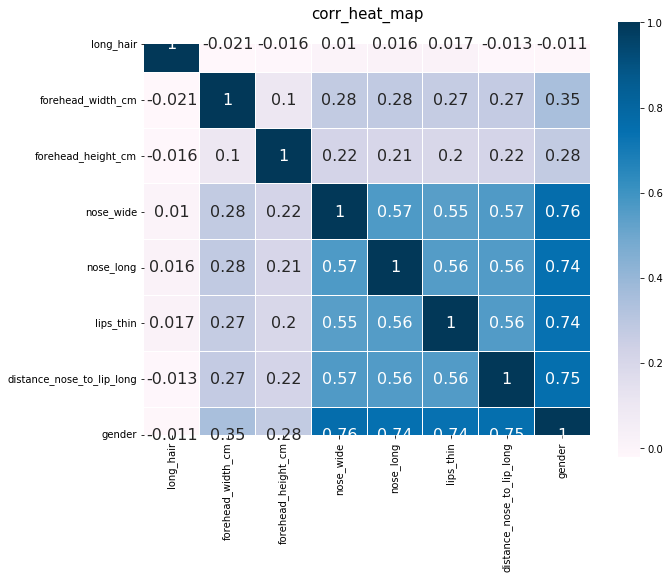

In [8]:
# 상관계수 히트맵
colormap = plt.cm.PuBu 
plt.figure(figsize=(10, 8)) 
plt.title("corr_heat_map", y = 1.05, size = 15) 
sns.heatmap(train.corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})


# Implement SVM

In [9]:
start = timeit.default_timer()

svc=SVC(kernel='linear', C = 100)
svc.fit(X_train, y_train)

stop = timeit.default_timer()
print('학습 소요시간 :',stop - start)

학습 소요시간 : 0.19216691700000865


In [10]:
y_pred = svc.predict(X_test)
metrics.confusion_matrix(y_test, y_pred)

array([[490,  11],
       [ 21, 479]])

In [11]:
print("Accuracy Score:")
print(metrics.accuracy_score(y_test, y_pred))
print("Recall Score:")
print(metrics.recall_score(y_test, y_pred))
print('Precision Score:')
print(metrics.precision_score(y_test, y_pred))

Accuracy Score:
0.968031968031968
Recall Score:
0.958
Precision Score:
0.9775510204081632


# Grid Search

In [12]:
values = [0.01, 0.1, 1, 10, 100]
param_grid = [{'kernel':['rbf'], 'C':values, 'gamma':values},
               {'kernel':['linear'], 'C':values}]
gs = GridSearchCV(SVC(), param_grid, cv= KFold(n_splits=5), scoring='accuracy', verbose = 3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=0.01, gamma=0.01, kernel=rbf, score=0.786, total=   0.4s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...... C=0.01, gamma=0.01, kernel=rbf, score=0.755, total=   0.4s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ...... C=0.01, gamma=0.01, kernel=rbf, score=0.870, total=   0.4s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=0.01, gamma=0.01, kernel=rbf, score=0.830, total=   0.4s
[CV] C=0.01, gamma=0.01, kernel=rbf ..................................
[CV] ...... C=0.01, gamma=0.01, kernel=rbf, score=0.866, total=   0.3s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.964, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.975, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.958, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.973, total=   0.2s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   26.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [13]:
print('optimal parameter ==> {}'.format(gs.best_params_))
print('optimal parameter의 점수 ==> {:.3f}'.format(gs.best_score_))
print('optimal parameter로 일반화 점수 ==> {:.3f}'.format(gs.score(X_test, y_test)))

optimal parameter ==> {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
optimal parameter의 점수 ==> 0.972
optimal parameter로 일반화 점수 ==> 0.972


In [20]:
svc_optimal=SVC(kernel='rbf', C = 10, gamma = 0.1)
svc_optimal.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
y_pred_optimal = svc_optimal.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_optimal)

array([[494,   7],
       [ 21, 479]])

# Pipeline

In [16]:
pip install --upgrade category_encoders

In [17]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy='most_frequent'))),
    ('svc', SVC(kernel='rbf', C = 10, gamma = 0.1)) 
])

pipe.fit(X_train, y_train);

In [18]:
y_pred = pipe.predict(X_test)
print('검증 정확도: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

검증 정확도:  0.972027972027972
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       501
           1       0.99      0.96      0.97       500

    accuracy                           0.97      1001
   macro avg       0.97      0.97      0.97      1001
weighted avg       0.97      0.97      0.97      1001



In [23]:
print('Accuracy Score:')
print(metrics.accuracy_score(y_test, y_pred_optimal))
print('Recall Score:')
print(metrics.recall_score(y_test, y_pred_optimal))
print('Precision Score:')
print(metrics.precision_score(y_test, y_pred_optimal))

Accuracy Score:
0.972027972027972
Recall Score:
0.958
Precision Score:
0.98559670781893


# 시각화

In [24]:
mini_df = df.sample(n=200, # number of items from axis to return.
          random_state=1004)

In [25]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

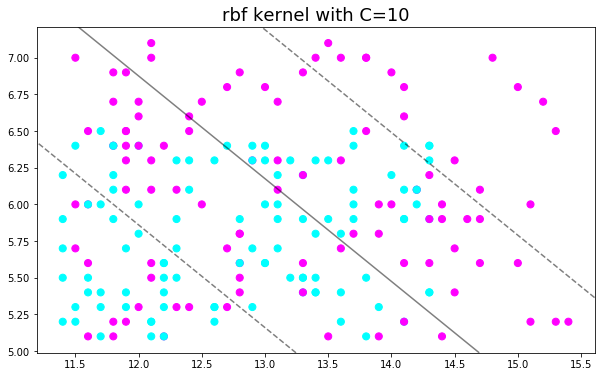

In [26]:
clf = SVC(C=0.1, kernel='linear').fit(np.array(X_train.iloc[:,1:3]), y_train)
plt.figure(figsize=(10,6))
plt.title("rbf kernel with C=10", fontsize=18)
plt.scatter(mini_df.iloc[:,1], mini_df.iloc[:,2], c=mini_df.iloc[:,-1], s=50, cmap='cool')
plot_svc_decision_function(clf)

# 이상적인 SVC의 시각화<br>
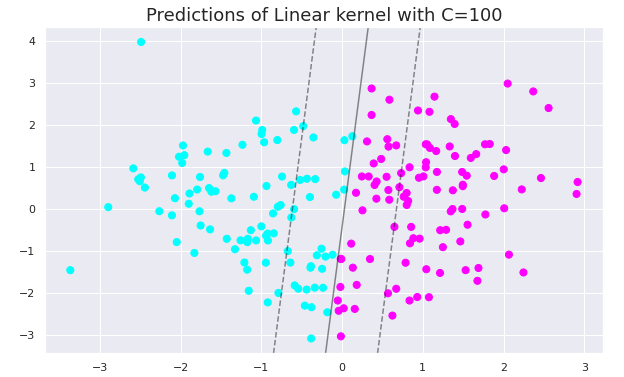


# Model Save
 - 최적화된 모델의 성능을 저장하여 다음 새로운 데이터에 input시킬 때, 바로 load가능함.



In [27]:
##### Save trained model
joblib.dump(pipe, './svc_gender.pkl') 

['./svc_gender.pkl']

# Permutation Importance(특성 중요도)
 - 양수는 유의미하다고 판단해도 무방, 음수부턴 의미 없음

In [28]:
svc=SVC(kernel='rbf', C = 10, gamma=0.1).fit(X_train, y_train)
perm = PermutationImportance(svc, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.to_list())

Weight,Feature
0.0553 ± 0.0091,nose_wide
0.0462 ± 0.0091,distance_nose_to_lip_long
0.0366 ± 0.0102,lips_thin
0.0342 ± 0.0075,forehead_width_cm
0.0338 ± 0.0051,nose_long
0.0110 ± 0.0057,forehead_height_cm
-0.0016 ± 0.0030,long_hair


# PDP
*   연속형, 범주형 나눠서 진행해야함



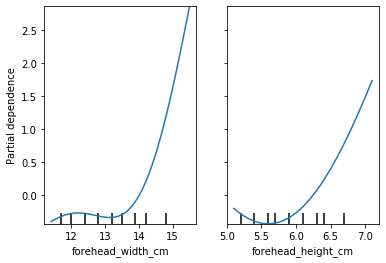

In [31]:
from sklearn.inspection import plot_partial_dependence, partial_dependence
plot_partial_dependence(svc, features=[1,2], X=X_train)

# 분석결과
forehead_width : 14cm기준으로 남녀로 분류될 확률이 높음<br>
forehead_height : 앞의 그래프보다 확실하지 않지만, 6cm기준으로 분류될 확률이 높음
